Install relation packages/libraries if not installed. Recommended to use a virtual environment!

In [1]:
# if not installed, install in local env
# !pip install --upgrade pip && \
# pip install hrvanalysis && \
# pip install plotly && \
# pip install pyarrow && \
# pip install fastparquet && \
# pip install seaborn && \
# pip install dask && \
# pip install pandas && \
# pip install scikit-learn && \
# pip install sktime && \
# pip install pmdarima && \
# pip install statsmodels

In [2]:
# general 
import pandas as pd 
import numpy as np 
import pickle

import pyarrow as pa
import pyarrow.parquet as pq

# stats
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 5)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# arima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.utils import plot_acf, plot_pacf, autocorr_plot
from pmdarima import model_selection


# from common files
from common import timeseries_evaluation_metrics_func, adfuller_test, grangers_causation_matrix

# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# load all dataframes
cgm_df = pd.read_parquet("Parquet Files/cgm_df.parquet.gzip")
final_df = pd.read_parquet("Parquet Files/final_df.parquet.gzip")
full_day_min_cgm = pd.read_parquet("Parquet Files/full_day_min_cgm.parquet.gzip")

## ARIMA

- Pure ARIMA for glucose (using time series split)
- ARIMAX with HRV exogenous variables (walk forward validation)
- VARMA with HRV exogenous variables (walk forward validation)

In [5]:
# split data into train, validation and test
# final day of test set for validation
TEST_SIZE = 0.125

# split using pmdarima's TTS to not shuffle data
train, test = train_test_split(final_df, test_size=TEST_SIZE)

print(f"Shape of train: {train.shape},\
 shape of test: {test.shape}")

Shape of train: (1098, 24), shape of test: (157, 24)


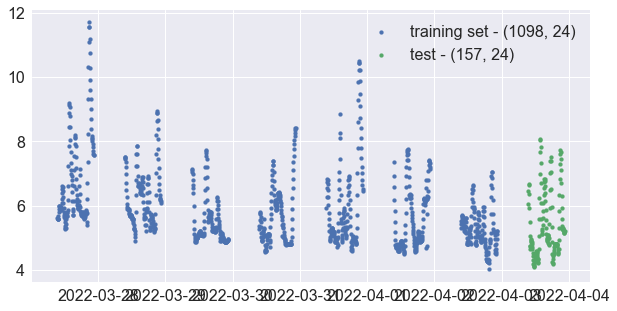

In [6]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=train['glucose'], x=train.index,
           label=f"training set - {train.shape}", s=15)
ax.scatter(y=test['glucose'], x=test.index,
           label=f"test - {test.shape}", s=15)
ax.legend()

In [7]:
# perform augmented dickey fuller test for unit root
adfuller_test(final_df['glucose'], name="Glucose")

    Augmented Dickey-Fuller Test on "Glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6327
 No. Lags Chosen       = 7
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



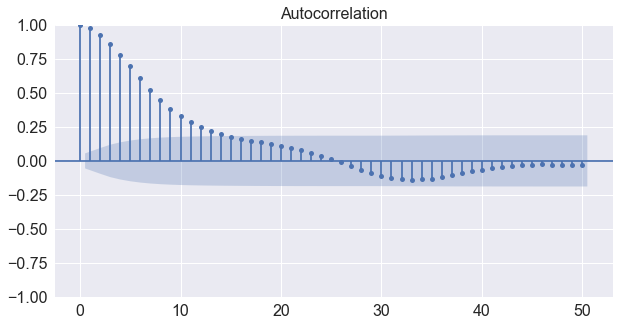

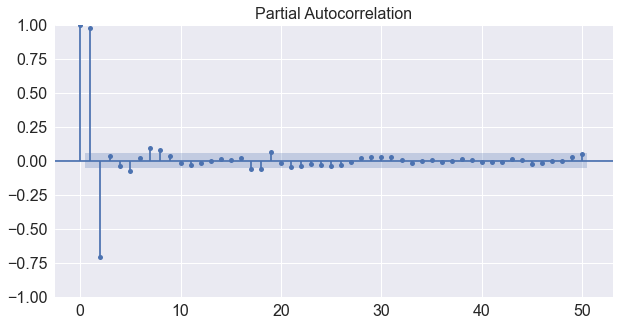

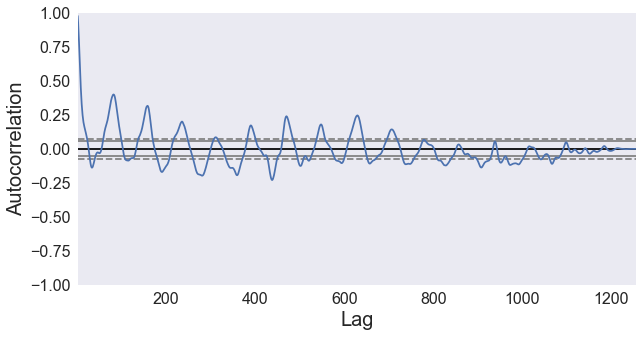

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
acf = plot_acf(final_df['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(10, 5))
pacf = plot_pacf(final_df['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(10, 5))
autocorr_plot(final_df['glucose'])

As seen, autocorrelation up til 10, and partial autocorrelation up to 3. Obvious signs of seasonality in glucose readings.

# ARIMA
Test a baseline ARIMA model (without walk forward validation)

In [9]:
model = pm.auto_arima(train['glucose'],
                      trace=True,
                      max_p=5, max_q=20, max_order=25,
                      stepwise=True,
                      seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-629.649, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.448, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-632.527, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-496.392, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.445, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-632.834, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-630.875, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-630.846, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-632.837, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-630.878, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-605.210, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-634.836, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-498.390, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-634.526, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]            

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1098
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 320.418
Date:                Fri, 06 May 2022   AIC                           -634.836
Time:                        15:07:37   BIC                           -619.835
Sample:                             0   HQIC                          -629.161
                               - 1098                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5810      0.025     23.636      0.000       0.533       0.629
ma.L1          0.0730      0.024      3.023      0.003       0.026       0.120
sigma2         0.0326      0.000    119.997      0.000       0.032       0.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            196782.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
test_pred, confint = model.predict(n_periods=len(test), return_conf_int=True)
arima_rmse = timeseries_evaluation_metrics_func(test['glucose'], test_pred)
print(f"Mean RMSE for ARIMA forecast: {arima_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 1.0296245735265677.


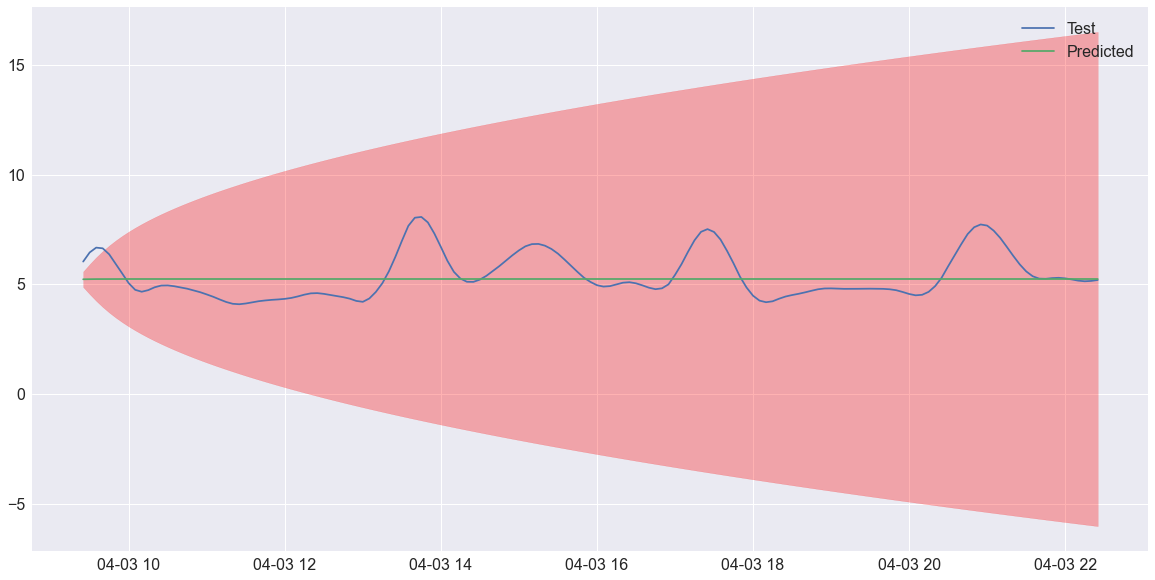

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(test['glucose'].index, test['glucose'], label='Test')
ax.plot(test['glucose'].index, test_pred, label='Predicted')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

# ARIMAX 
ARIMA + exogenous variables from HRV time domain/frequence domain features
> https://robjhyndman.com/hyndsight/arimax/

final_df information:
- 5 minute data from 0925 to 2224 hours from day 1 to day 8 (13 hours per day)
- Shape: (1255, 24)

Stationarity checks with ADFuller

In [13]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(final_df)

    Augmented Dickey-Fuller Test on "glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6327
 No. Lags Chosen       = 7
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "mean_nni" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5315
 No. Lags Chosen       = 15
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "sdnn" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [14]:
fig = px.scatter(final_df)
fig.show()

In [15]:
# using pmdarima's cross validation predict
# works, but doesnt provide granular access to predicitons in each window
est = pm.ARIMA(order=(13, 1, 2),#(13, 1, 2),
               seasonal_order=(0, 0, 0, 157),
               suppress_warnings=True)

y = final_df['glucose']
X = final_df.drop('glucose', axis=1)

cv = model_selection.RollingForecastCV(h=24, step=24, initial=1098)
predictions = model_selection.cross_val_predict(
    est, y=y, X=X, cv=cv, verbose=2, averaging="median")

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


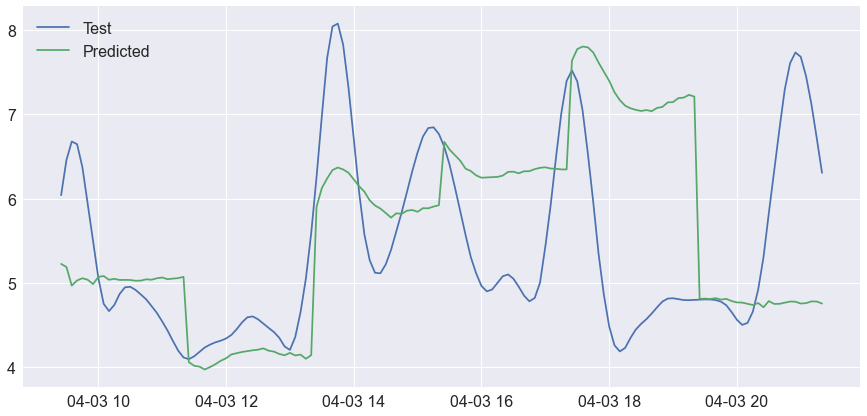

In [16]:
pred_df = pd.DataFrame(data=predictions,
                       index=final_df.index[1098:-13],
                       columns=['Predictions'])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(final_df['glucose'][1098:-13], label="Test")
ax.plot(pred_df, label="Predicted")
ax.legend(loc='best')
fig.show()

In [17]:
cross_validate_split = pm.model_selection.RollingForecastCV(h=24, step=24, initial=1098)

forecaster = pm.ARIMA(order=(13, 1, 2),
                      seasonal_order=(0, 0, 0, 157),
                      suppress_warnings=True)

def rolling_validator(generator, y_data, model, X_data=None):
    """Walk forward forecasting using fixed train set and moving test set

    Args:
        generator (pmdarima forecaster object): Either rollingforecast or slidingforecast generators from pmdarima
        y_data (Iterable): Pandas series or numpy array of values to forecast
        model (Forecast Model): A model compatible with sci-kit learn's API of fit, predict
        X_data (Pandas Dataframe, optional): Optional exogenous data to use. Defaults to None.

    Returns:
        Tuple: A tuple of a list of predictions for each window, a list of rmse errors for each window, and mae errors
        for each window
    """
    # make generator
    cv_generator = generator.split(y=y_data, X=X_data)
    all_predictions, rmse_err, mae_err = [], [], []
    
    # loop through array, perform fit + predict
    for window in cv_generator:
        
        # endog
        y_train = y_data.iloc[window[0]]
        y_test = y_data.iloc[window[1]]
        
        # exog
        X_train = X_data.iloc[window[0]]
        X_test = X_data.iloc[window[1]]
        
        
        # perform forecast
        model.fit(y=y_train, X=X_train)
        y_pred = model.predict(X=X_test, n_periods=len(y_test))  

        # # compute errors
        err = timeseries_evaluation_metrics_func(y_true=y_test.values,
                                                 y_pred=y_pred)
        
        # append values for plotting
        all_predictions.append(y_pred)
        rmse_err.append(err["rmse"])
        mae_err.append(err["mae"])
    
        
    return all_predictions, rmse_err, mae_err

In [18]:
%%time
i, j, k = rolling_validator(cross_validate_split,
                            y_data=final_df['glucose'],
                            X_data=final_df.drop('glucose', axis=1),
                            model=forecaster)

Wall time: 44.1 s


In [19]:
arimax_rmse = np.mean(j)
arimax_mae = np.mean(k)
print (f"RMSE is {arimax_rmse}, MAE is {arimax_mae}")

RMSE is 1.1787040912744422, MAE is 0.9927890326156574


In [20]:
pred_df = pd.DataFrame(data=np.concatenate(i).ravel(),
                       index=final_df.index[1098:-13],
                       columns=['Predictions'])

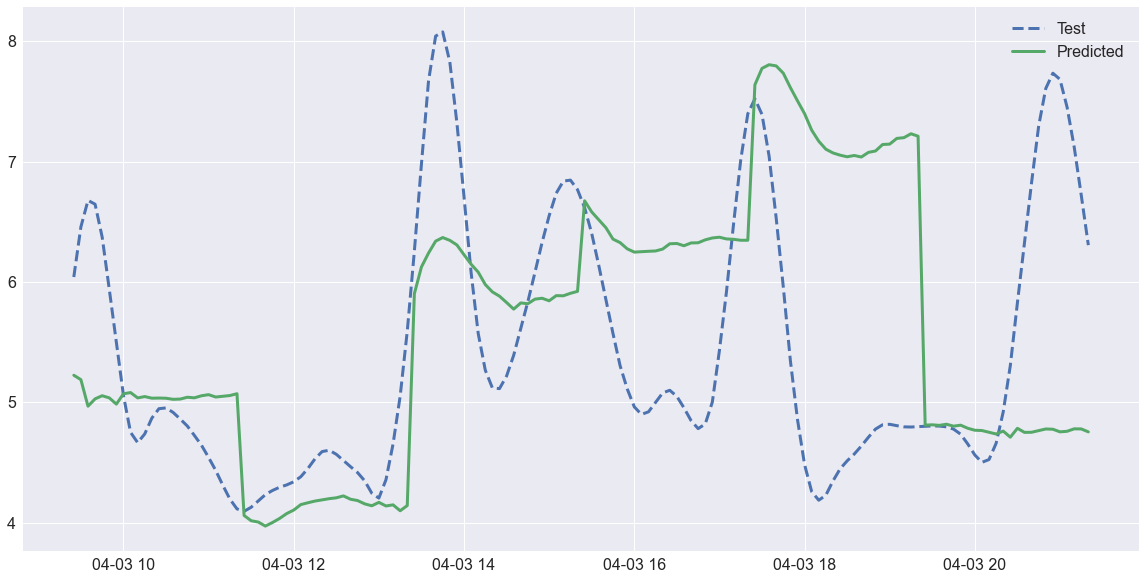

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(final_df['glucose'][1098:-13], label="Test", linewidth=3, linestyle='dashed')
ax.plot(pred_df, linewidth=3, label="Predicted")
ax.legend(loc='best')
fig.show()

In [22]:
# final day of test set for validation
TEST_SIZE_PERCENT = 0.125

# split using pmdarima's TTS to not shuffle data
y_train, y_test = train_test_split(final_df, test_size=TEST_SIZE_PERCENT)
print(f"Shape of train: {y_train.shape}, shape of test: {y_test.shape}")

Shape of train: (1098, 24), shape of test: (157, 24)


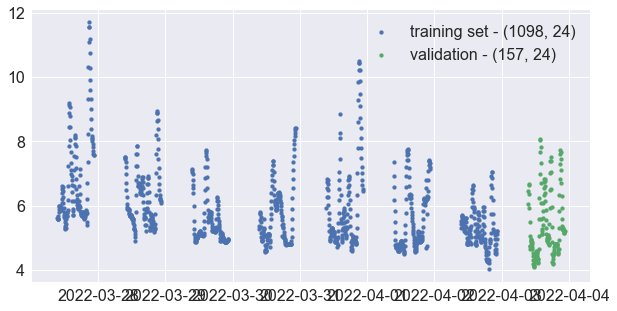

In [23]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=y_train['glucose'], x=y_train.index, label=f"training set - {y_train.shape}", s=15)
ax.scatter(y=y_test['glucose'], x=y_test.index, label=f"validation - {y_test.shape}", s=15)
ax.legend()

Possible params for p term: 13, q term: 3.

# VARMAX
Since data is multivariate, a forecast attempt can be made with each column as a vector, modelling each column as lagged regressors of the other features + t-lag time series. Focusing only on 'glucose'.

Granger Casuality Test

Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

>https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [24]:
matrix = grangers_causation_matrix(final_df, variables=final_df.columns)
matrix

,glucose_x,mean_nni_x,sdnn_x,sdsd_x,nni_50_x,pnni_50_x,nni_20_x,pnni_20_x,rmssd_x,median_nni_x,...,max_hr_x,min_hr_x,std_hr_x,lf_x,hf_x,lf_hf_ratio_x,lfnu_x,hfnu_x,total_power_x,vlf_x
glucose_y,1.0000,0.0000,0.0060,0.0010,0.0004,0.0003,0.0075,0.0012,0.0010,0.0000,...,0.1125,0.1005,0.0783,0.0512,0.0495,0.0787,0.0038,0.0038,0.0029,0.0033
mean_nni_y,0.0560,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6311,...,0.1785,0.1452,0.0000,0.0000,0.0001,0.0749,0.5908,0.5908,0.0000,0.0000
sdnn_y,0.0057,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0023,0.0001,0.0000,0.0000,0.0002,0.0005,0.0005,0.0000,0.0084
sdsd_y,0.0004,0.0000,0.1259,1.0000,0.0000,0.0000,0.0000,0.0000,0.0161,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0089,0.0650,0.0650,0.0819,0.1485
nni_50_y,0.0055,0.0000,0.2274,0.0636,1.0000,0.0000,0.0041,0.0000,0.0634,0.0000,...,0.0001,0.2044,0.0057,0.0000,0.0023,0.0005,0.0083,0.0083,0.1607,0.2830
pnni_50_y,0.0214,0.0000,0.0036,0.0433,0.0005,1.0000,0.3615,0.0001,0.0432,0.0000,...,0.0120,0.2079,0.1004,0.0003,0.0002,0.0327,0.0655,0.0655,0.0960,0.0132
nni_20_y,0.0076,0.0001,0.2715,0.0456,0.0384,0.0092,1.0000,0.0097,0.0457,0.0020,...,0.0123,0.9118,0.3931,0.0037,0.0607,0.0023,0.0085,0.0085,0.7868,0.5424
pnni_20_y,0.0003,0.0022,0.0000,0.0170,0.0085,0.0908,0.1699,1.0000,0.0168,0.0800,...,0.1594,0.5353,0.0243,0.0125,0.0286,0.0039,0.0234,0.0234,0.0013,0.0000
rmssd_y,0.0004,0.0000,0.1269,0.0163,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0089,0.0649,0.0649,0.0826,0.1497
median_nni_y,0.0023,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.2247,0.0246,0.0015,0.0005,0.0003,0.0309,0.3017,0.3017,0.0000,0.0000


*_x are the independent variables, *_y are dependent variables. First row is of interest (only glucose_y)
- For most attributes (e.g. mean_nni_x, sdnn_x, etc) the null hypothesis of 0.05 is the threshold for which the x variable granger causes y
- Most variables seem to granger cause *_y.

In [25]:
rel_metrics = matrix.iloc[0]
GRANGER_THRESHOLD = 0.05

def metric_select(srs, threshold=GRANGER_THRESHOLD):
    # drop metrics that fail 0.05 granger null hypothesis threshold
    s = srs.copy()
    for idx, metric in s.iteritems():
        if metric >= GRANGER_THRESHOLD:
            s.drop(idx, inplace=True)
    return s

def extract_metrics(srs):
    keys = list(srs.keys())
    return [i[:-2] for i in keys]

useful_varma_features = extract_metrics(metric_select(rel_metrics)) #

# add glucose
useful_varma_features.insert(0, 'glucose')

In [26]:
# train_best_feat = y_train[feat]
train_best_feat = final_df[useful_varma_features]
print(f"Features to use: {useful_varma_features}")

Features to use: ['glucose', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'hf', 'lfnu', 'hfnu', 'total_power', 'vlf']


In [27]:
from dask.distributed import Client
client = Client(threads_per_worker=3, n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54304,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.95 GiB
Comm: tcp://127.0.0.1:54333,Total threads: 3
Dashboard: http://127.0.0.1:54336/status,Memory: 7.99 GiB
Nanny: tcp://127.0.0.1:54307,


In [28]:
import dask
import re

@dask.delayed
def extract_ideal_pdq(s):
    param = re.findall("S?ARIMA+X?\(([0-9]+), ([0-9]+), ([0-9]+)", s)
    p, d, q = int(param[0][0]) , int(param[0][1]) , int(param[0][2])
    return (p, d, q)

@dask.delayed
def feat_search(df_col, col, p=10, d=10, q=10):
    model = pm.arima.AutoARIMA(max_p=p, max_d=d, max_q=q, test='adf',
                               max_order=None, seasonal=True,
                               max_iter=100, suppress_warnings=True)
    model.fit(df_col)
    return str(model.summary())

def parallel_autoarima(df):
    r = []
    for column in df.columns:
        sum = feat_search(df[column], column)
        order = extract_ideal_pdq(sum)
        r.append((column, order))
    return r

In [29]:
%%time
jobs = parallel_autoarima(train_best_feat)
ideal_params = dask.compute(*jobs)

Wall time: 2min 31s


In [30]:
for p in ideal_params:
    print(p) # narrow VAR hyperparameter search to p and q from individual feature list

('glucose', (2, 0, 0))
('mean_nni', (3, 0, 5))
('sdnn', (1, 0, 3))
('sdsd', (1, 0, 2))
('nni_50', (2, 0, 1))
('pnni_50', (1, 0, 2))
('nni_20', (1, 0, 2))
('pnni_20', (1, 0, 3))
('rmssd', (1, 0, 2))
('median_nni', (2, 0, 4))
('range_nni', (5, 0, 0))
('cvsd', (2, 0, 3))
('cvnni', (1, 0, 0))
('mean_hr', (4, 0, 2))
('hf', (2, 0, 1))
('lfnu', (1, 0, 4))
('hfnu', (3, 0, 2))
('total_power', (4, 0, 6))
('vlf', (2, 0, 0))


Shape of train: (784, 24), shape of validation: (314, 24),  shape of test: (157, 24)


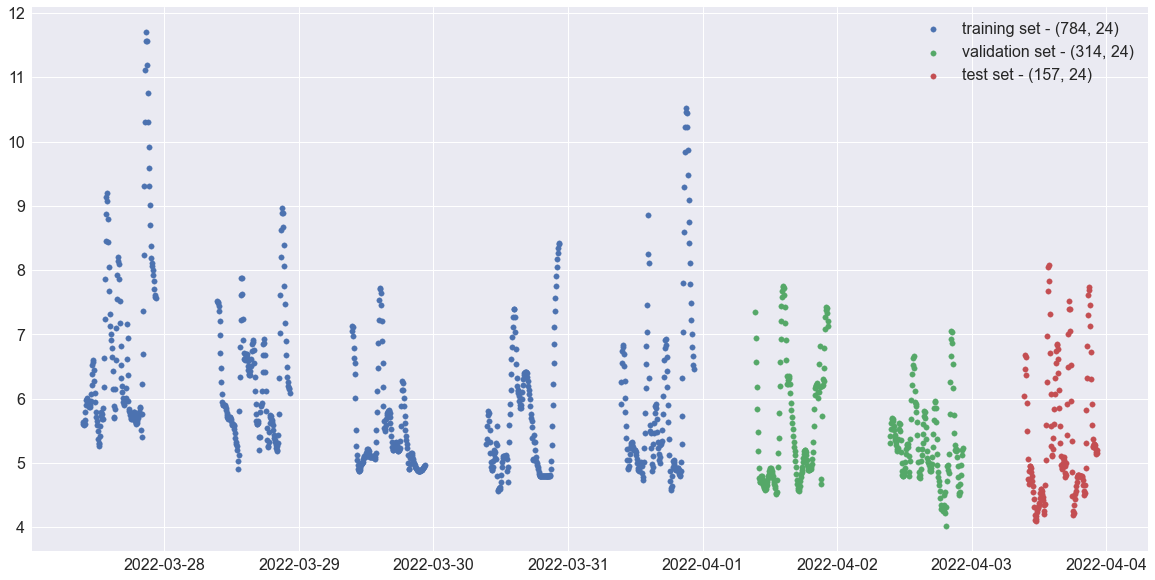

In [31]:
# split data into train, validation and test
# final day of test set for validation
TEST_SIZE = 0.125
VAL_SIZE = 0.285714

# split using pmdarima's TTS to not shuffle data
temp, test = train_test_split(final_df, test_size=TEST_SIZE)

# get validation data from train set
train, val = train_test_split(temp, test_size=VAL_SIZE)
print(f"Shape of train: {train.shape}, shape of validation: {val.shape}, \
 shape of test: {test.shape}")

# plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y=train['glucose'], x=train.index,
           label=f"training set - {train.shape}", s=30)
ax.scatter(y=val['glucose'], x=val.index,
           label=f"validation set - {val.shape}", s=30)
ax.scatter(y=test['glucose'], x=test.index,
           label=f"test set - {test.shape}", s=30)
ax.legend()

In [32]:
# scale features on a column basis
from sklearn.compose import ColumnTransformer
FEATURES_TO_USE = useful_varma_features

ct = ColumnTransformer(
    [("scaler", MinMaxScaler(),
      FEATURES_TO_USE)])

scaled_train = ct.fit_transform(train)
scaled_val = ct.transform(val)

In [33]:
y_train_feat_scaled = pd.DataFrame(scaled_train,
                                columns=useful_varma_features,
                                index=train.index)

y_test_feat_scaled = pd.DataFrame(scaled_val,
                            columns=useful_varma_features,
                            index=val.index)

In [34]:
# extract unique ideal params possibilities
param_combinations= list(set([(_[1][0], _[1][2]) for _ in ideal_params]))
print(param_combinations)

[(1, 2), (3, 2), (1, 3), (4, 6), (2, 1), (1, 4), (2, 0), (2, 3), (5, 0), (4, 2), (1, 0), (2, 4), (3, 5)]


In [35]:
# with too many features, VARMA doesn't seem to work (non-positive estimate, or linear alg error).
# select a subset for features for VARMA
s_features = ['glucose',
              'sdnn',
              'rmssd',
              'median_nni',
              'range_nni',
              'cvsd',
              'cvnni',
              'hf',
              'total_power',
              'vlf']

y_train_feat_scaled = y_train_feat_scaled[s_features]
y_test_feat_scaled = y_test_feat_scaled[s_features]

In [36]:
@dask.delayed
def varma_harness(params, order):  
    model = VARMAX(endog=params, order=order)
    return model

@dask.delayed
def varma_fit_forecast(model, pred_len):
    res = model.fit()
    fcast = res.get_forecast(pred_len)
    return fcast

@dask.delayed
def eval_model(fcast, test):
    metrics = timeseries_evaluation_metrics_func(fcast, test)
    return metrics

def gridsearch_varma(train, test, possible_params, target='glucose'):
    r = []
    for combi in possible_params:
        mod = varma_harness(train, order=combi)
        fcast = varma_fit_forecast(mod, len(test))
        results = eval_model(test[target], fcast.predicted_mean[target])
        r.append((combi, results, fcast))
    return r

If running notebook for first time, gridsearch varma parameters on validation set by running cell below, else load directly from pickle files

In [37]:
%%time
# jobs = gridsearch_varma(y_train_feat_scaled,  y_test_feat_scaled, param_combinations) # 30 min runtime
# varma_scores = dask.compute(*jobs)

# save varma score for future runs
# with open('Pickle Files/varma_gridsearch_val_set_pkl', 'wb') as files:
#     pickle.dump(varma_scores, files)

Wall time: 0 ns


In [38]:
# if not first time running, load pickle file directly
with open('Pickle Files/varma_gridsearch_val_set_pkl', 'rb') as file:
    varma_scores = pickle.load(file)

In [39]:
pd.DataFrame(varma_scores) # p=1, q=0 has the best scores

,0,1,2
0,"(1, 2)","{'rmse': 0.8950520070661521, 'mae': 0.78755244...",<statsmodels.tsa.statespace.mlemodel.Predictio...
1,"(3, 2)","{'rmse': 0.8698584565695986, 'mae': 0.77093804...",<statsmodels.tsa.statespace.mlemodel.Predictio...
2,"(1, 3)","{'rmse': 0.895078685946037, 'mae': 0.788565518...",<statsmodels.tsa.statespace.mlemodel.Predictio...
3,"(4, 6)","{'rmse': 0.8742604670728515, 'mae': 0.77462900...",<statsmodels.tsa.statespace.mlemodel.Predictio...
4,"(2, 1)","{'rmse': 0.8650492274674878, 'mae': 0.76803707...",<statsmodels.tsa.statespace.mlemodel.Predictio...
5,"(1, 4)","{'rmse': 0.8948936654341061, 'mae': 0.78694835...",<statsmodels.tsa.statespace.mlemodel.Predictio...
6,"(2, 0)","{'rmse': 0.8645465518614766, 'mae': 0.76722881...",<statsmodels.tsa.statespace.mlemodel.Predictio...
7,"(2, 3)","{'rmse': 0.8674942864918613, 'mae': 0.76989888...",<statsmodels.tsa.statespace.mlemodel.Predictio...
8,"(5, 0)","{'rmse': 0.880448395465219, 'mae': 0.779255965...",<statsmodels.tsa.statespace.mlemodel.Predictio...
9,"(4, 2)","{'rmse': 0.8767993197201872, 'mae': 0.77657424...",<statsmodels.tsa.statespace.mlemodel.Predictio...


In [40]:
# extract p, q params with smallest RMSE
def get_best_var_params(scores, score_column=1, score="rmse"):
    lowest = 1
    best = None
    
    for i in scores:
        rmse = i[score_column][score]
        if rmse < lowest:
            lowest = rmse
            best = i
    return best
        
var_param = get_best_var_params(varma_scores) # best model as shown
var_param

((2, 0),
 {'rmse': 0.8645465518614766,
  'mae': 0.7672288123348407,
  'mse': 0.7474407403355688,
  'mape': 102.82860651307529,
  'r2': -0.6808814111004657},
 <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x17b1e5b99c8>)

In [41]:
# # attempt to parallelize varma walkforward, did not do it eventually
# @dask.delayed
# def varma_harness(scaled_train, scaled_test, order):  
#     model = VARMAX(endog=scaled_train, order=order)
#     res = model.fit()
#     fcast = res.get_forecast(steps=len(scaled_test))
#     return fcast

# @dask.delayed
# def eval_model(fcast, test):
#     metrics = timeseries_evaluation_metrics_func(fcast, test)
#     return metrics

# def scale_data(y_train, y_test, scaler=StandardScaler()):
#     scaled_train = scaler.fit_transform(y_train)
#     scaled_test = scaler.transform(y_test)
#     return scaled_train, scaled_test, scaler


# def varma_walkforward(list_of_windows, y_data, order=(2, 0)):
#     all_predictions, rmse_err, mae_err = [], [], []
#     for window in list_of_windows:
        
#         # make window
#         y_train = y_data.iloc[window[0]]
#         y_test = y_data.iloc[window[1]]
        
#         # scale data
#         scaler = StandardScaler()
#         scaled_train = scaler.fit_transform(y_train)
#         scaled_test = scaler.transform(y_test)
        
#         # fit and get predictions
#         fcast = varma_harness(scaled_train, scaled_test, order=order)
#         y_pred = fcast.predicted_mean

#         # evaluate model
#         err = eval_model(scaled_test, y_pred)
        
#         # add all results to respective lists
#         all_predictions.append(scaler.inverse_transform(y_pred))
#         rmse_err.append(err["rmse"])
#         mae_err.append(err["mae"])
        
#     return all_predictions, rmse_err, mae_err


# cross_validate_split = pm.model_selection.RollingForecastCV(h=24, step=24, initial=1098)
# cv_generator = cross_validate_split.split(y=final_df[s_features])
# all_windows = list(cv_generator)

# # %%time
# jobs = varma_walkforward(all_windows, final_df)
# varma_scores = dask.compute(*jobs)

In [42]:
# walkforward validation of VARMA model using best params obtained from training
cross_validate_split = pm.model_selection.RollingForecastCV(h=24, step=24, initial=1098)

def varmax_validator(generator, y_data, order=(1, 0)):
    """Walk forward VARMA forecast using fixed train set and moving test set (unscaled)

    Args:
        generator (pmdarima forecaster object): Either rollingforecast or slidingforecast generators from pmdarima
        y_data (Iterable): Pandas series or numpy array of values to forecast
        order (tuple, optional): VARMA P and Q orders. Defaults to (1, 0).

    Returns:
        Tuple: A tuple of a list of predictions for each window, a list of rmse errors for each window, and mae errors
        for each window
    """
    # make generator
    cv_generator = generator.split(y=y_data)
    all_predictions, rmse_err, mae_err = [], [], []
    
    # loop through array, perform fit + predict
    for window in cv_generator:
        
        # endog
        y_train = y_data.iloc[window[0]]
        y_test = y_data.iloc[window[1]]

        # perform forecast
        model = VARMAX(endog=y_train, order=order)
        res = model.fit()
        fcast = res.get_forecast(steps=len(y_test))
        y_pred = fcast.predicted_mean['glucose'].values
        
        # compute errors
        err = timeseries_evaluation_metrics_func(y_true=y_test['glucose'].values,
                                                 y_pred=y_pred)
        
        # append values for plotting
        all_predictions.append(y_pred)
        rmse_err.append(err["rmse"])
        mae_err.append(err["mae"])
        
    return all_predictions, rmse_err, mae_err

i, j, k = varmax_validator(cross_validate_split,
                            y_data=final_df[s_features],
                            order=(2, 0))

In [43]:
pred_df = pd.DataFrame(data=np.concatenate(i).ravel(),
                       index=final_df.index[1098:-13],
                       columns=['Predictions'])

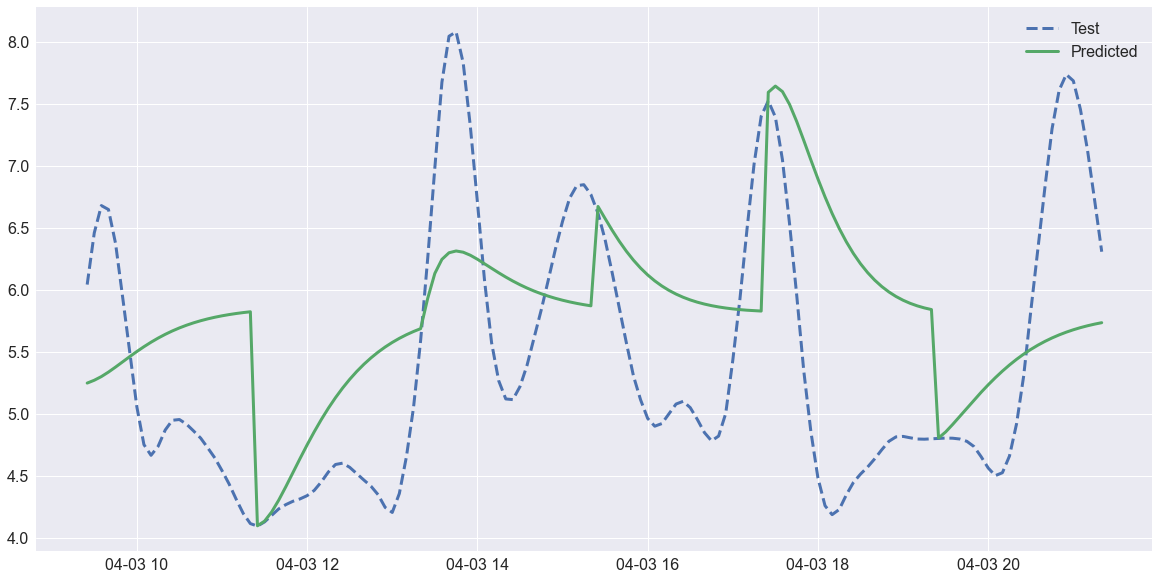

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(final_df['glucose'][1098:-13], label="Test", linewidth=3, linestyle='dashed')
ax.plot(pred_df, linewidth=3, label="Predicted")
ax.legend(loc='best')
fig.show()

In [45]:
rmse = np.mean(j)
mae = np.mean(k)
print (f"RMSE is {rmse}, MAE is {mae}")

RMSE is 1.0421288070043684, MAE is 0.9128914303635964
